C:\Users\Ayush\anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[*********************100%%**********************]  5 of 5 completed
                 AAPL       AMZN      GOOGL        MSFT       TSLA
Date                                                              
2020-01-02  72.876129  94.900497  68.355545  153.938202  28.684000
2020-01-03  72.167603  93.748497  67.997955  152.021423  29.534000
2020-01-06  72.742661  95.143997  69.810379  152.414368  30.102667
2020-01-07  72.400543  95.343002  69.675537  151.024612  31.270666
2020-01-08  73.565186  94.598503  70.171463  153.430283  32.809334


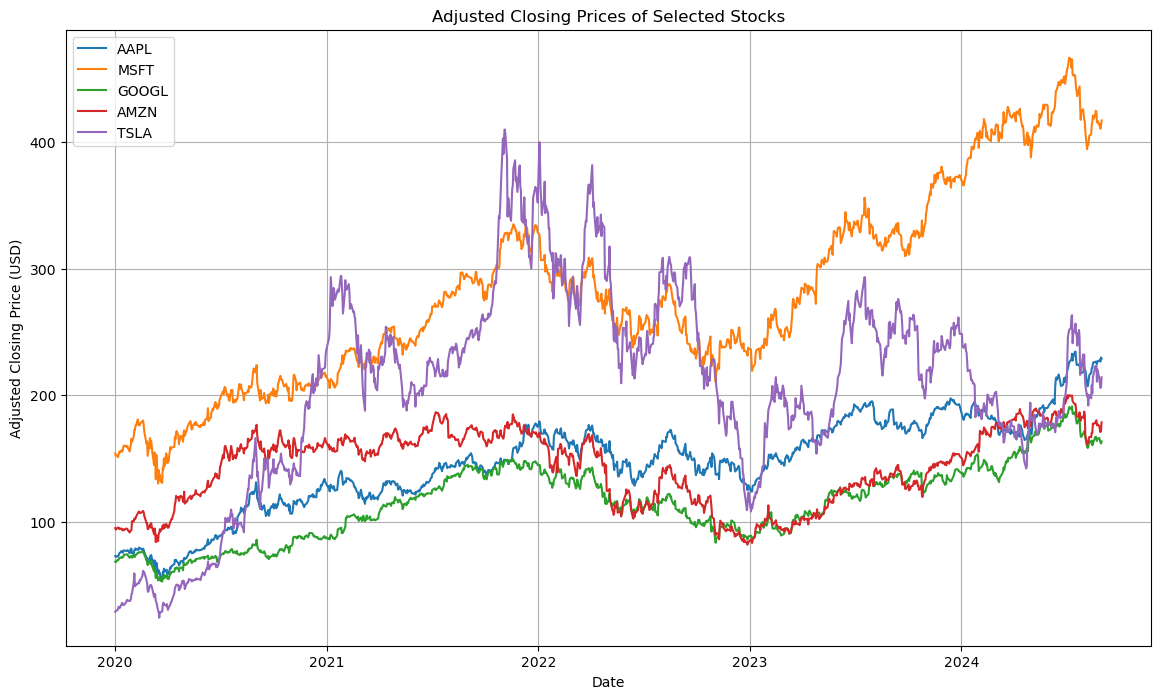

In [1]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'TSLA']


data = yf.download(tickers, start='2020-01-01', end='2024-08-31')['Adj Close']


print(data.head())


plt.figure(figsize=(14, 8))
for ticker in tickers:
    plt.plot(data[ticker], label=ticker)
plt.title('Adjusted Closing Prices of Selected Stocks')
plt.xlabel('Date')
plt.ylabel('Adjusted Closing Price (USD)')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()


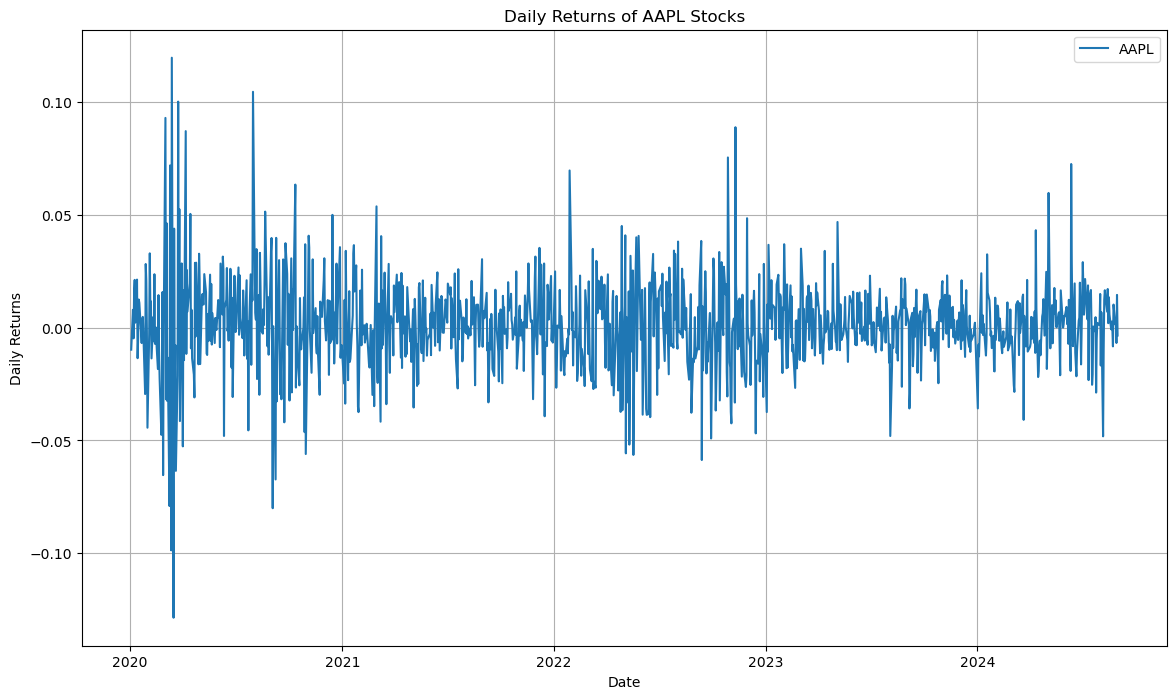

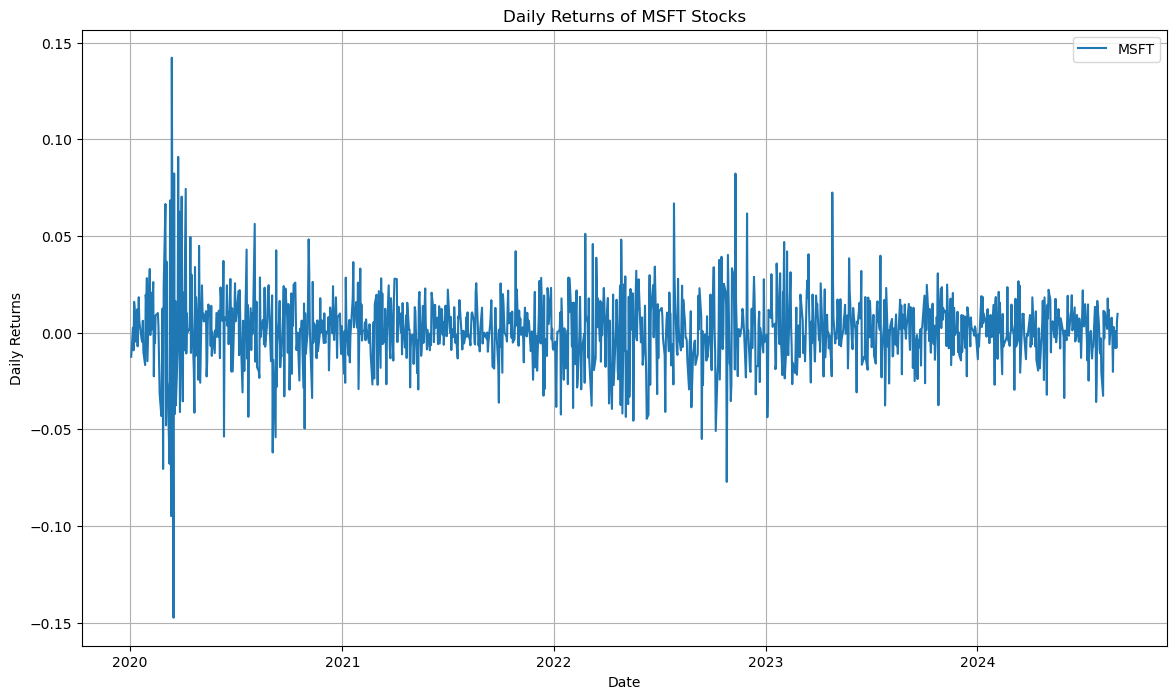

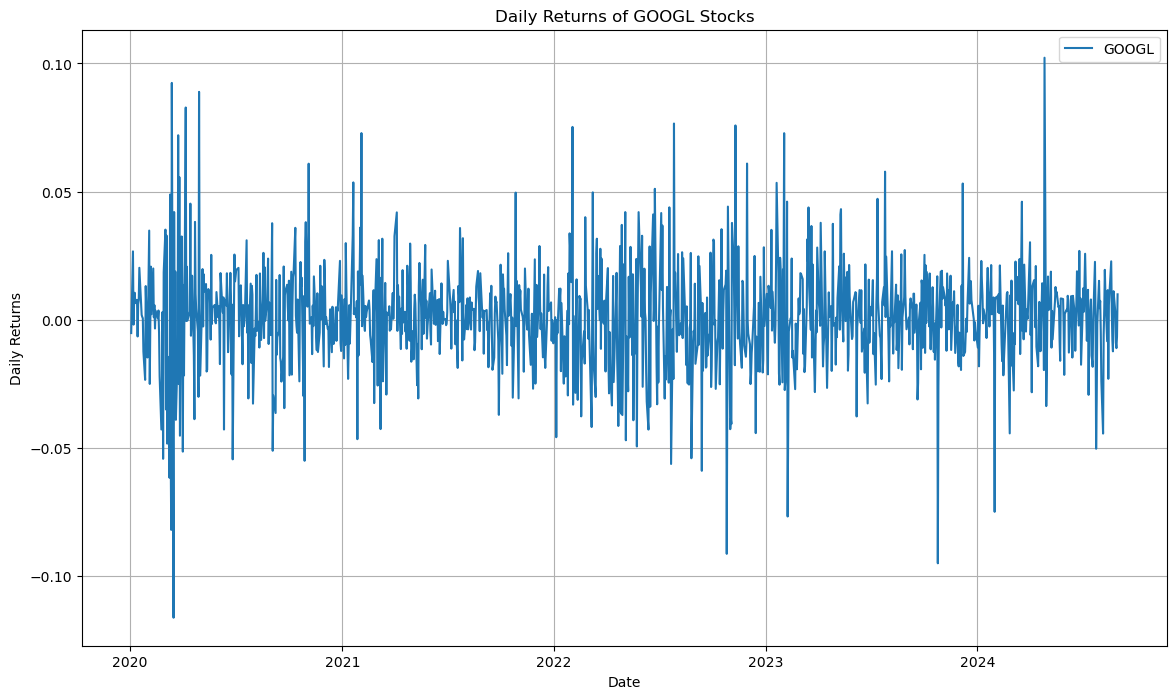

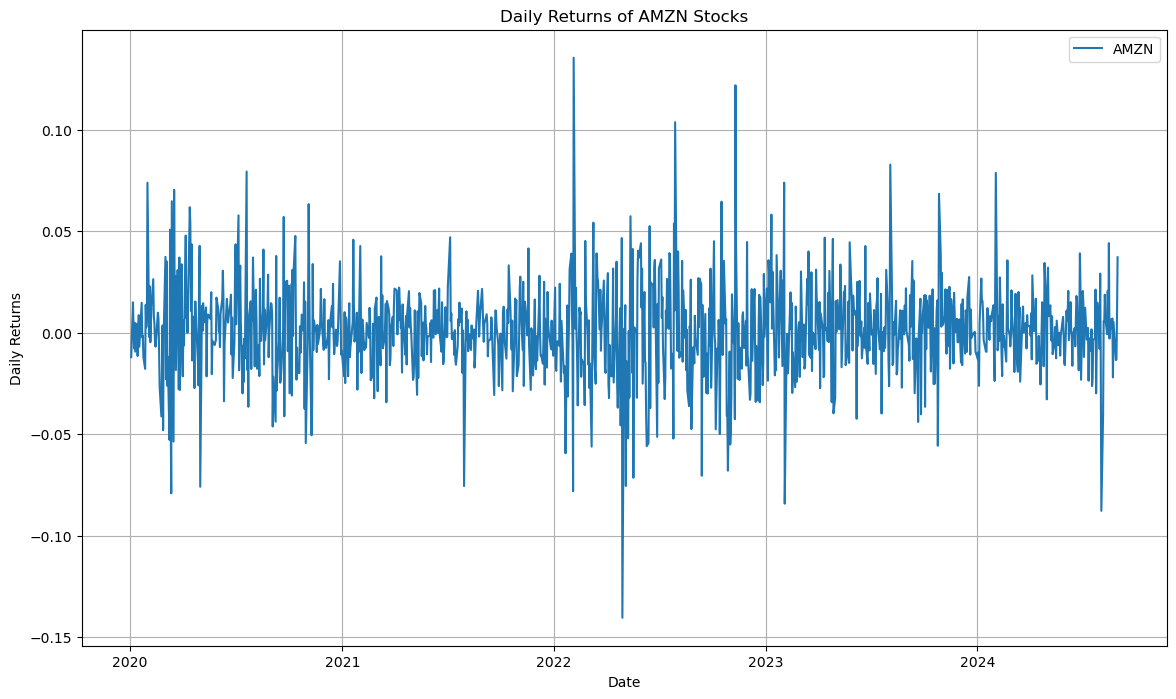

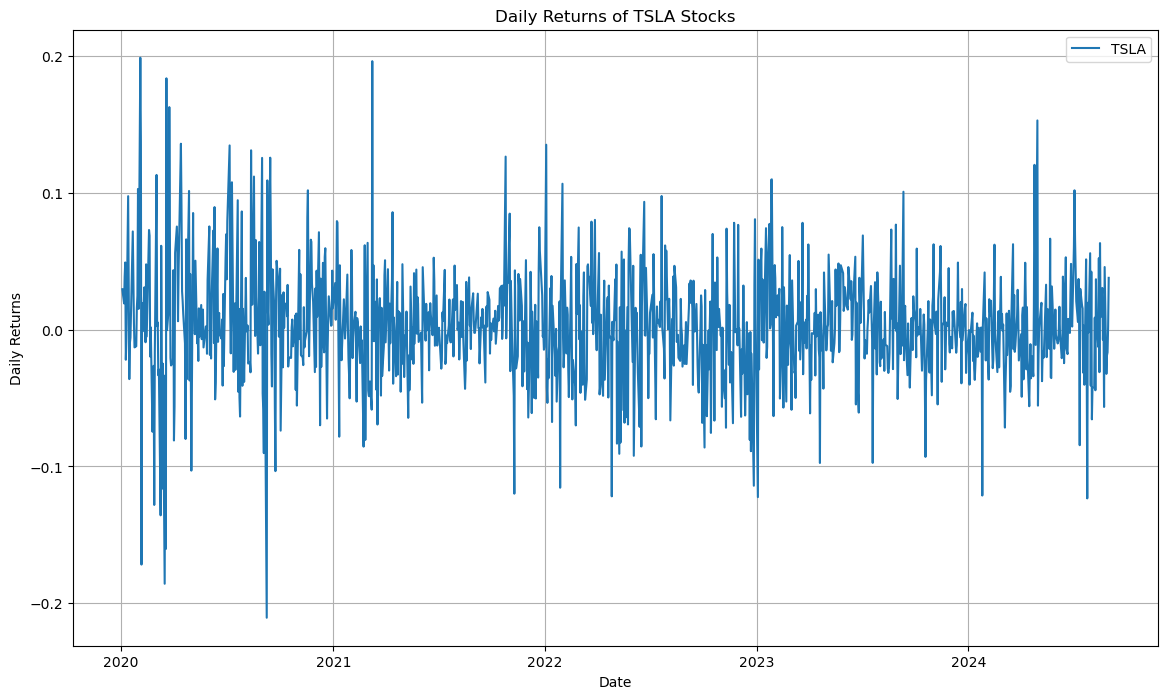

In [6]:

returns = data.pct_change().dropna()

for ticker in tickers:
    plt.figure(figsize=(14, 8))

    plt.plot(returns[ticker], label=ticker)
    plt.title('Daily Returns of {} Stocks'.format(ticker))
    plt.xlabel('Date')
    plt.ylabel('Daily Returns')
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.show()


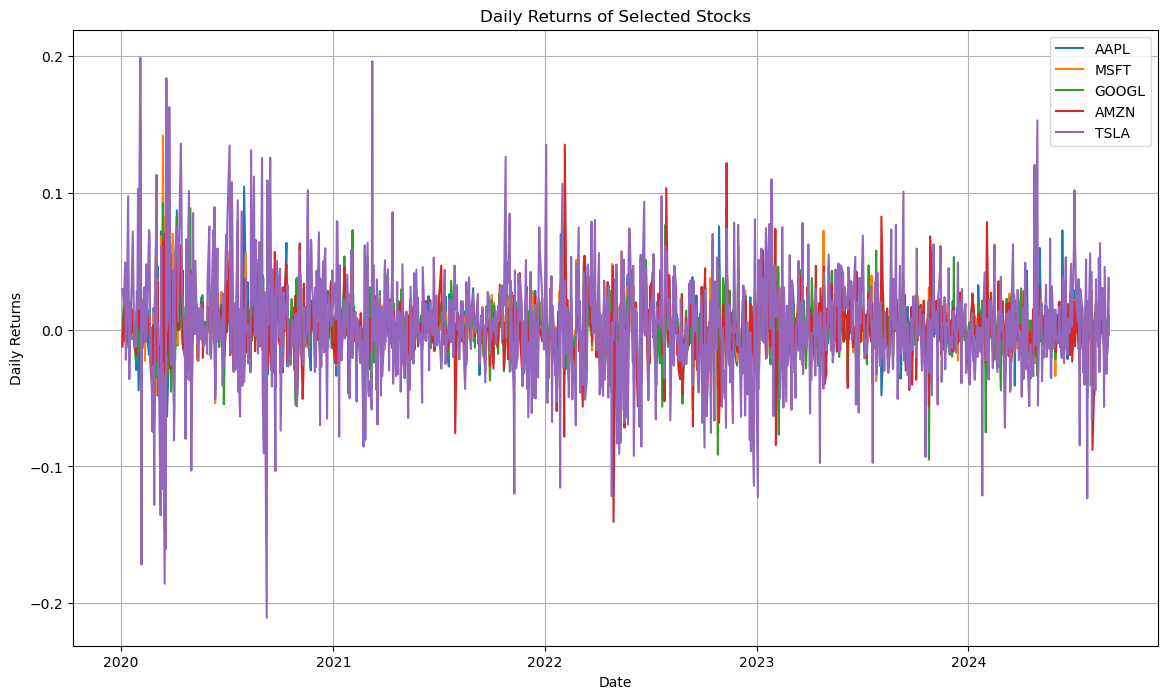

In [9]:
plt.figure(figsize=(14, 8))
for ticker in tickers:
    plt.plot(returns[ticker], label=ticker)
plt.title('Daily Returns of Selected Stocks')
plt.xlabel('Date')
plt.ylabel('Daily Returns')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

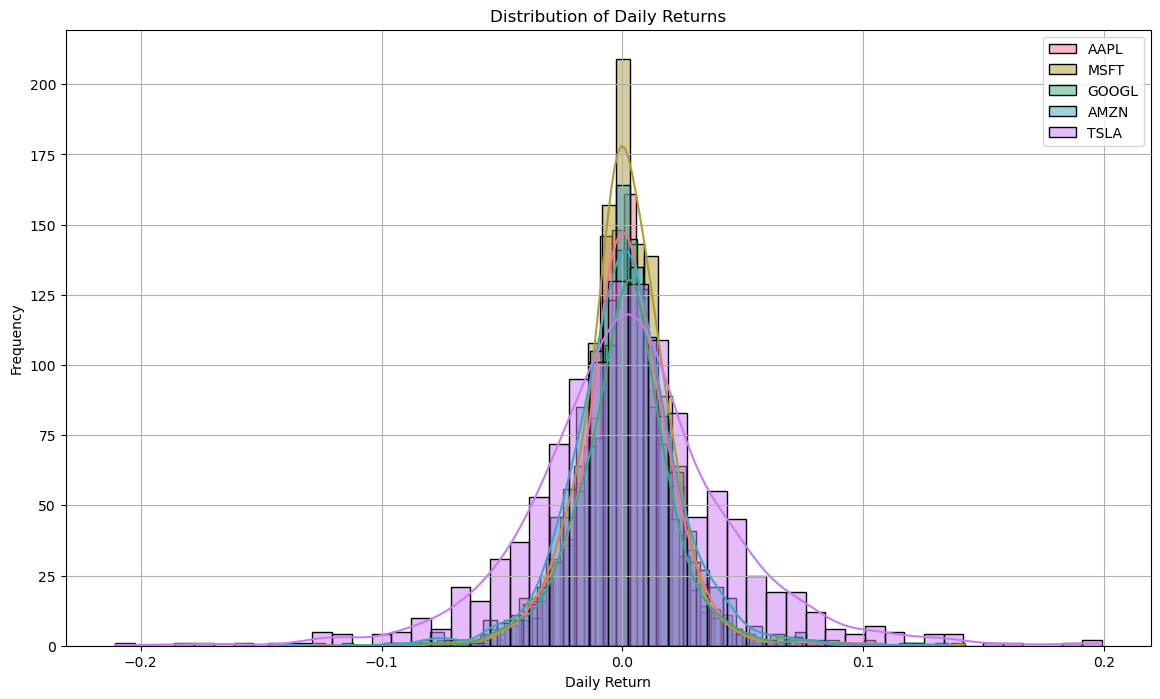

In [8]:
colors = sns.color_palette('husl', len(tickers))

plt.figure(figsize=(14, 8))

for i, ticker in enumerate(tickers):
    sns.histplot(returns[ticker], bins=50, kde=True, label=ticker, color=colors[i])

plt.title('Distribution of Daily Returns')
plt.xlabel('Daily Return')
plt.ylabel('Frequency')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()


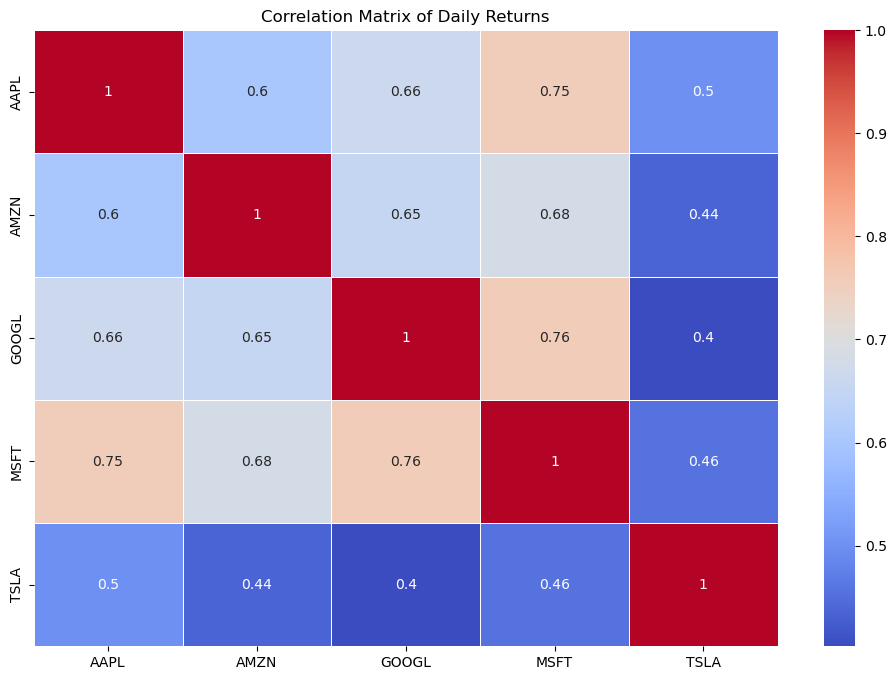

In [10]:

corr_matrix = returns.corr()


plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix of Daily Returns')
plt.show()


In [11]:
import numpy as np


mean_returns = returns.mean()
cov_matrix = returns.cov()


mean_returns_annual = mean_returns * 252
cov_matrix_annual = cov_matrix * 252

print("Annualized Mean Returns:\n", mean_returns_annual)
print("\nAnnualized Covariance Matrix:\n", cov_matrix_annual)


Annualized Mean Returns:
 AAPL     0.298474
AMZN     0.202024
GOOGL    0.241028
MSFT     0.262576
TSLA     0.654548
dtype: float64

Annualized Covariance Matrix:
            AAPL      AMZN     GOOGL      MSFT      TSLA
AAPL   0.104959  0.070838  0.070341  0.076005  0.108128
AMZN   0.070838  0.132683  0.077859  0.076798  0.106299
GOOGL  0.070341  0.077859  0.107483  0.077275  0.088020
MSFT   0.076005  0.076798  0.077275  0.096665  0.094569
TSLA   0.108128  0.106299  0.088020  0.094569  0.445423


In [12]:
def portfolio_performance(weights, mean_returns, cov_matrix, risk_free_rate=0.01):
    returns = np.sum(weights * mean_returns)
    std_dev = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    sharpe_ratio = (returns - risk_free_rate) / std_dev
    return returns, std_dev, sharpe_ratio


In [21]:
from scipy.optimize import minimize

def neg_sharpe(weights, mean_returns, cov_matrix, risk_free_rate=0.01):
    return -portfolio_performance(weights, mean_returns, cov_matrix, risk_free_rate)[2]

def optimize_portfolio(mean_returns, cov_matrix, num_portfolios=10000, risk_free_rate=0.01):
    num_assets = len(mean_returns)
    bounds = tuple((0, 1) for _ in range(num_assets))
    result = minimize(neg_sharpe, num_assets * [1. / num_assets,], args=(mean_returns, cov_matrix, risk_free_rate),
                      method='SLSQP', bounds=bounds, constraints=({'type': 'eq', 'fun': lambda x: np.sum(x) - 1}))
    return result


optimal_portfolio = optimize_portfolio(mean_returns_annual, cov_matrix_annual)

print("Optimal Portfolio Weights:\n", optimal_portfolio.x)




Optimal Portfolio Weights:
 [0.4151395  0.         0.03726471 0.20305851 0.34453727]


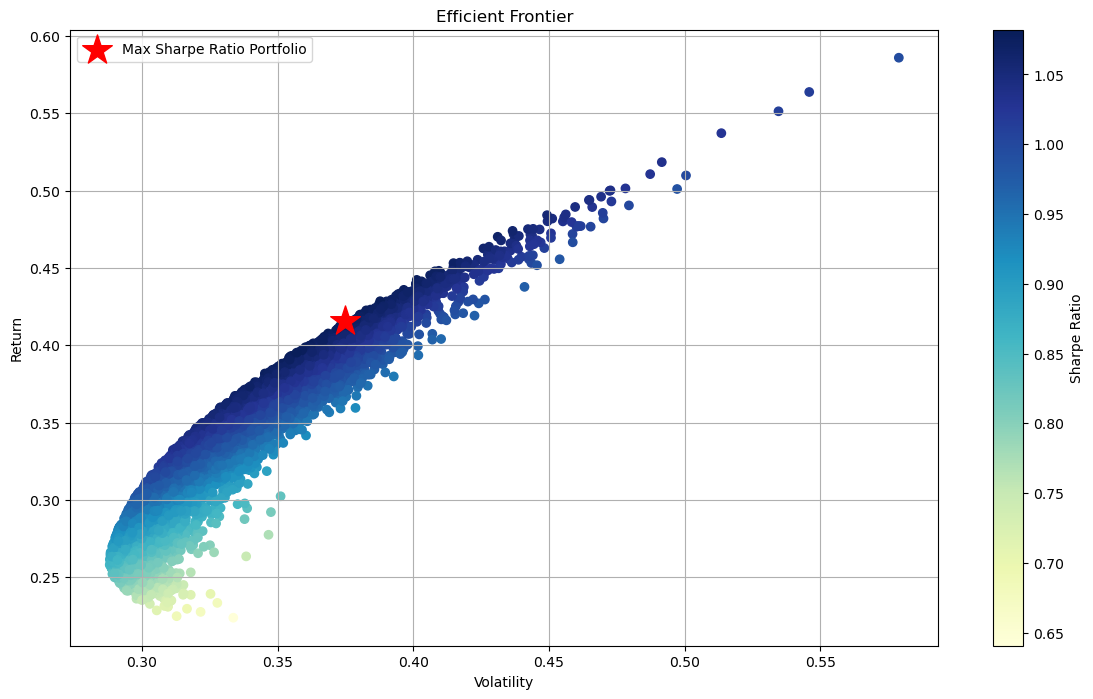

In [22]:
def plot_efficient_frontier(mean_returns, cov_matrix, optimal_portfolio, num_portfolios=10000, risk_free_rate=0.01):
    results = np.zeros((3, num_portfolios))
    weights_record = []
    
    for i in range(num_portfolios):
        weights = np.random.random(len(mean_returns))
        weights /= np.sum(weights)
        portfolio_return, portfolio_std_dev, portfolio_sharpe = portfolio_performance(weights, mean_returns, cov_matrix, risk_free_rate)
        
        results[0,i] = portfolio_return
        results[1,i] = portfolio_std_dev
        results[2,i] = portfolio_sharpe
        
        weights_record.append(weights)
    
    max_sharpe_idx = np.argmax(results[2])
    max_sharpe_port = results[:,max_sharpe_idx]
    
    plt.figure(figsize=(14, 8))
    plt.scatter(results[1,:], results[0,:], c=results[2,:], cmap='YlGnBu', marker='o')
    plt.title('Efficient Frontier')
    plt.xlabel('Volatility')
    plt.ylabel('Return')
    plt.colorbar(label='Sharpe Ratio')
    
    plt.scatter(max_sharpe_port[1], max_sharpe_port[0], marker='*', color='r', s=500, label='Max Sharpe Ratio Portfolio')
    plt.legend(loc='upper left')
    plt.grid(True)
    plt.show()

plot_efficient_frontier(mean_returns_annual, cov_matrix_annual, optimal_portfolio)


In [15]:
from scipy.optimize import differential_evolution

def optimize_with_ga(mean_returns, cov_matrix, risk_free_rate=0.01):
    bounds = [(0, 1) for _ in range(len(mean_returns))]
    result = differential_evolution(neg_sharpe, bounds, args=(mean_returns, cov_matrix, risk_free_rate))
    return result.x

ga_weights = optimize_with_ga(mean_returns_annual, cov_matrix_annual)
print("Optimal Portfolio Weights using GA:\n", ga_weights)


Optimal Portfolio Weights using GA:
 [1.         0.         0.18534842 0.74715539 1.        ]


In [17]:
from sklearn.preprocessing import StandardScaler


X = returns[:-1]
y = returns[1:]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


nn_model = Sequential([
    Dense(128, input_dim=X_train.shape[1], activation='relu'),
    Dense(64, activation='relu'),
    Dense(len(tickers), activation='linear')
])

nn_model.compile(optimizer='adam', loss='mse')
nn_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))


predicted_returns = nn_model.predict(X_test)



Epoch 1/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 7.3689e-04 - val_loss: 8.1865e-04
Epoch 2/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6.4302e-04 - val_loss: 8.1979e-04
Epoch 3/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6.4088e-04 - val_loss: 8.1304e-04
Epoch 4/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6.8880e-04 - val_loss: 8.0807e-04
Epoch 5/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6.1877e-04 - val_loss: 8.0400e-04
Epoch 6/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6.6441e-04 - val_loss: 8.1322e-04
Epoch 7/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6.3147e-04 - val_loss: 8.0471e-04
Epoch 8/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6.5786e-04 - val_loss: 8.0375e-04
Epoch 9/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6.4183e-04 - val_loss: 8.1002e-04
Epoch 10/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6.6305e-04 - val_loss: 8.0332e-04
Epoch 11/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6.4394e-04 - val_los

Annualized Return: 0.41
Annualized Volatility: 0.37


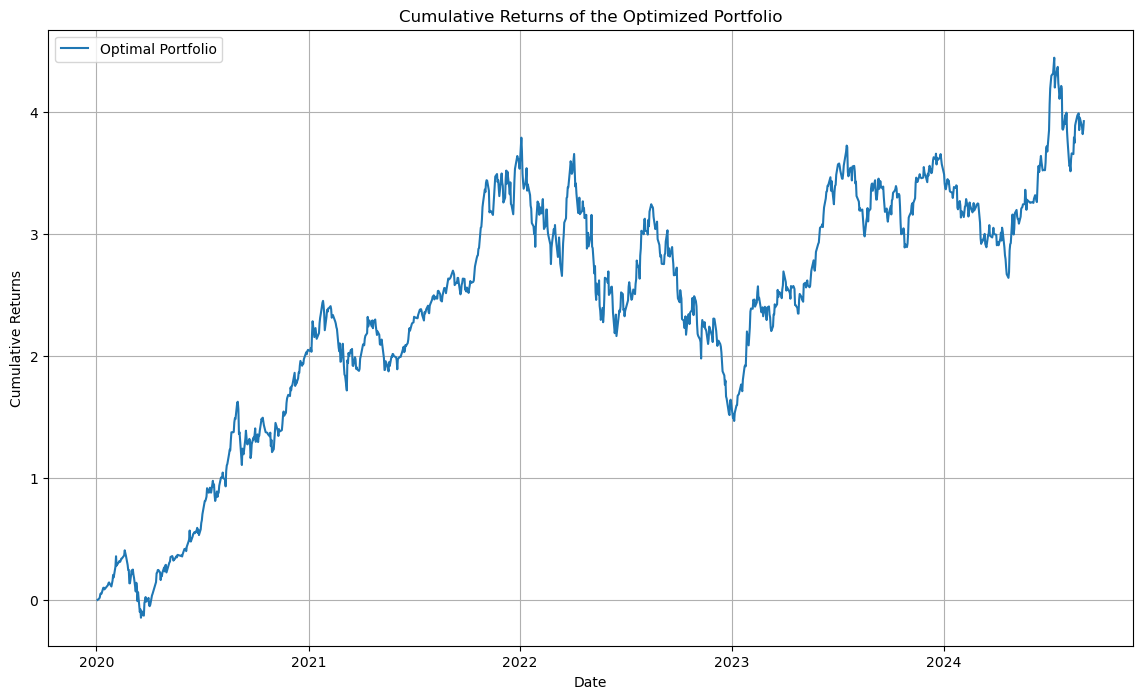

In [23]:
def backtest_portfolio(weights, data):
    
    returns = data.pct_change().dropna()
    portfolio_returns = returns.dot(weights)
    
   
    cumulative_returns = (1 + portfolio_returns).cumprod() - 1
    total_return = cumulative_returns.iloc[-1]
    annualized_return = (1 + total_return) ** (252 / len(cumulative_returns)) - 1
    annualized_volatility = portfolio_returns.std() * np.sqrt(252)
    
    return cumulative_returns, annualized_return, annualized_volatility

cumulative_returns, annualized_return, annualized_volatility = backtest_portfolio(optimal_portfolio.x, data)

print(f"Annualized Return: {annualized_return:.2f}")
print(f"Annualized Volatility: {annualized_volatility:.2f}")


plt.figure(figsize=(14, 8))
plt.plot(cumulative_returns, label='Optimal Portfolio')
plt.title('Cumulative Returns of the Optimized Portfolio')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()


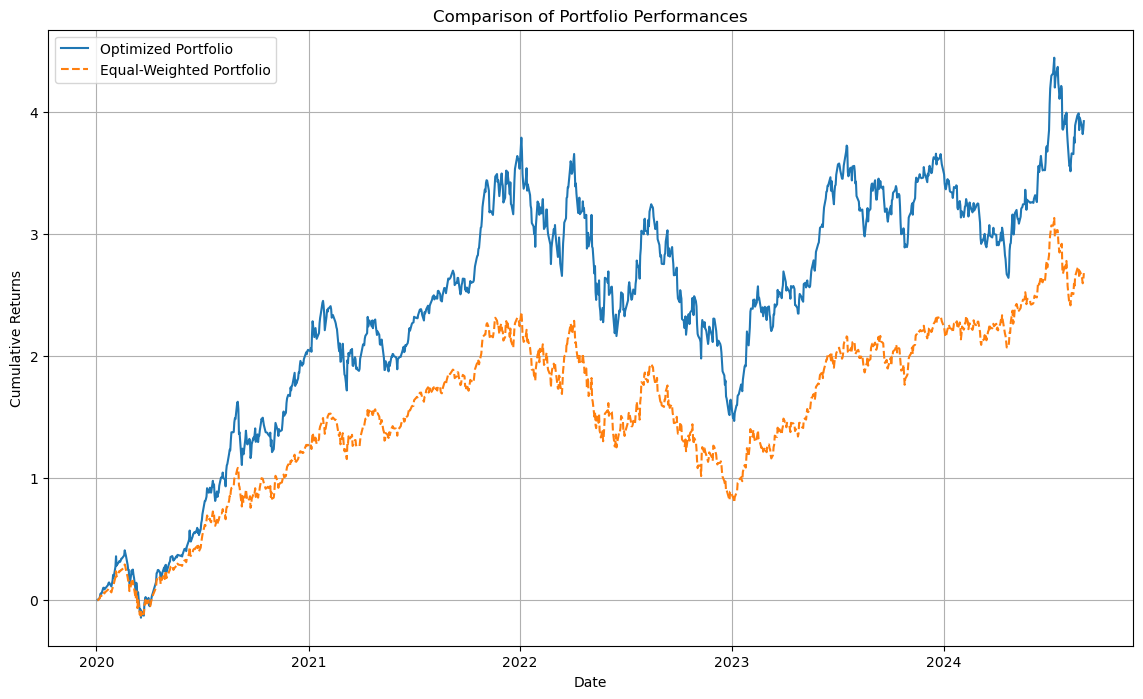

In [24]:

equal_weights = np.ones(len(tickers)) / len(tickers)
cumulative_returns_equal, annualized_return_equal, annualized_volatility_equal = backtest_portfolio(equal_weights, data)


plt.figure(figsize=(14, 8))
plt.plot(cumulative_returns, label='Optimized Portfolio')
plt.plot(cumulative_returns_equal, label='Equal-Weighted Portfolio', linestyle='--')
plt.title('Comparison of Portfolio Performances')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()
